# Kernel methods

## 1- Load forecasting dataset

In this tutorial, we illustrate kernel methods on the load forecasting dataset from *Human spatial dynamics for electricity demand forecasting: the case of France during the 2022 energy crisis* (Doumèche et al., 2023), available at [https://zenodo.org/records/10041368](https://zenodo.org/records/10041368).


In [ ]:
import pandas as pd

url = "https://zenodo.org/records/10041368/files/dataset_national.csv"
df = pd.read_csv(url) # Takes about 30 seconds

This dataset contains measurements of the French national electricity load, along with calendar and temperature data.
From this dataset, we extract the dataset *df_daily* which contains the daily average of the following features

* the day, in the feature *day*,
* the French electricity load, in the variable *Load*,
* the French average temperature, in the variable *temperature*.

In [ ]:
df['date'] = pd.to_datetime(df['date'])

# Remove the hours and seconds from the date
df['day'] = df['date'].dt.normalize()

# Group by date and compute the mean
df_daily = df.groupby('day')[['temperature', 'Load']].mean().reset_index()

To better understand the data at hand, we plot the electricity load as a function of time.

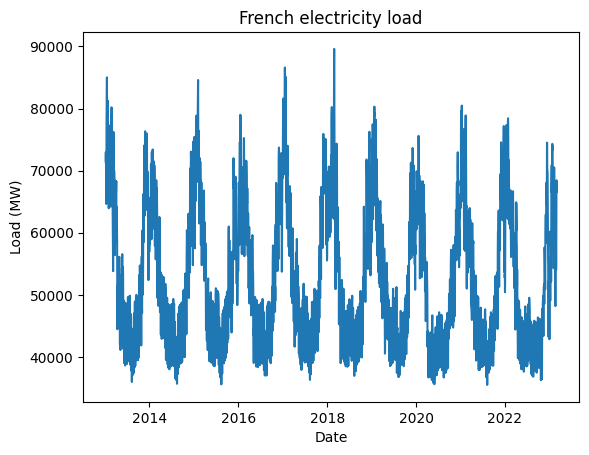

In [ ]:
import matplotlib.pyplot as plt

plt.plot(df_daily['day'], df_daily['Load'])
plt.xlabel('Date')
plt.ylabel('Load (MW)')
plt.title('French electricity load')
plt.show()

**Goal.** The goal of this tutorial is to learn the function $f^\star$ such that $$Load_t = f^\star(Temp_t)+\varepsilon_t,$$
where $Load_t$ is the French national electricity load at time $t$ and $Temp_t$ is the temperature at time $t$.

**Question 1:** To better visualize the effect of temperature on load, plot the variable *Load* as a function of the variable *temperature*.

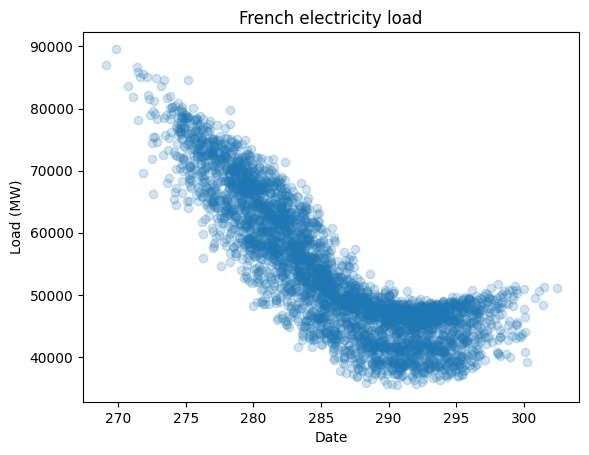

In [ ]:
plt.scatter(df_daily['temperature'], df_daily['Load'], alpha=0.2)
plt.xlabel('Date')
plt.ylabel('Load (MW)')
plt.title('French electricity load')
plt.show()

## 2- Polynomial kernel

**Goal.** The goal of this tutorial is to learn the function $f^\star$ such that $$Y = f^\star(X)+\varepsilon,$$
where $Y = Load$ is the French national electricity load and $$X = \frac{temperature- \min(temperature)}{2(\max(temperature)-\min(temperature))}$$ is the rescaled temperature, i.e., $X\in [0,0.5]$.

### 2.1 - Mathematical setting: building polynomial kernels

To solve this nonparametric task, we can consider the model
$$f_\theta(x) = \theta_0 + \theta_1 x + \theta_2 x^2 + \dots + \theta_{m} x^m,$$
where $\theta =(\theta_0, \dots, \theta_{m})\in \mathbb R^{m+1}$.
This consists in expending the function $f^\star$ on the polynomial basis.

**Question 2:**
Assume $f^\star$ is a continuous function. Explain why, as $m$ grows, the approximation error
$$\inf_{\theta\in \mathbb R^{m+1}} \|f_\theta-f^\star\|_{\infty, [0,0.5]}$$
vanishes. Here, $\|\cdot\|_{\infty, [0,1]}$ is the sup-norm on the interval $[0,0.5]$.

**Answer.**
<details>
  <summary>  (Click to show)</summary>
This is a consequence of the Weierstrass approximation theorem.
</details>

**Question 3:** What is the map $\phi: [0, 0.5] \to \mathbb R^{m+1}$ such that $f_\theta(x) = \langle \phi(x), \theta\rangle$ ?

**Answer.**
<details>
  <summary>  (Click to show)</summary>
  $\phi(x) = (1, x, x^2, \dots, x^m)$.
</details>

**Question 4.** Given $\lambda>0$, we consider the empirical risk
$$L(\theta) = \frac{1}{n}\sum_{i=1}^n (f_\theta(X_i)-Y_i)^2 + \lambda\|\theta\|_2^2.$$

a) What is the role of the Ridge penalty $\lambda\|\theta\|_2^2$?

b) Recall why $L$ has a unique minimizer
$$\hat \theta = argmin_{\mathbb R^{m+1}} L.$$

c) Show that $$\hat \theta = (\Phi^\top\Phi/n + \lambda I)^{-1}\Phi^* \mathbb Y/n,$$ where $I$ is the identity matrix, $\mathbb Y = (Y_1, \dots, Y_n)^\top$ and
$$\Phi = \begin{pmatrix}\phi(X_1)^\top\\\vdots\\\phi(X_n)^\top\end{pmatrix}.$$


**Answers.**
<details>
  <summary>  (Click to show)</summary>

a) The Ridge penalty aims at avoiding averfitting if $m$ is large.

b) $L$ is strictly convex in $\theta$.  Moreover, if $\|\theta\|_2^2 \geq \frac{2}{n\lambda}\sum_{i=1}^n Y_i^2$, then $L(\theta) \geq 2 L(0)$. Since the ball $B = \{\theta, \;\|\theta\|_2^2 \geq \frac{2}{n\lambda}\sum_{i=1}^n Y_i^2\}$ is compact and $L$ is continuous, we know that $L$ has a local minimum inside the interior of ball $B$. Since $L$ is convex, this local minimum is a global minimum and is unique.

c) We solve the equation $\nabla L = 0$. Note that $$L(\theta) = \frac{1}{n}\|\Phi \theta-\mathbb Y\|_2^2 + \lambda\|\theta\|_2^2.$$
Thus, by writing $\|\Phi \theta-\mathbb Y\|_2^2 = \langle \Phi \theta-\mathbb Y, \Phi \theta-\mathbb Y\rangle$, we see that
$$L(\theta+\delta \theta) = L(\theta) + \langle \frac{1}{n}\Phi^\top(\Phi\theta -\mathbb Y)+ \lambda \theta, \delta \theta\rangle + o_{\|\delta\theta\|_2\to \infty}(\|\delta\theta\|_2) .$$
Thus, $\nabla L(\theta) = {2}{n}\Phi^\top(\Phi\theta -\mathbb Y)+ 2\lambda \theta$ and $\nabla L =0$ results in $\hat \theta = (\Phi^\top\Phi/n + \lambda I)^{-1}\Phi^\top \mathbb Y/n$.

</details>


**Question 5.** The goal is now to compute $f_{\hat \theta}$ in practice.

a) What are the dimensions of the matrix $\Phi^\top\Phi/n + \lambda I$?

b) By definition,
$$f_{\hat \theta}(x) = \langle \phi(x), \hat\theta\; \rangle = \phi(x)^\top (\Phi^\top\Phi/n + \lambda I)^{-1}\Phi^\top \mathbb Y/n. $$

Prove the following result, known as the *kernel trick*:
$$f_{\hat \theta}(x) = \phi(x)^\top \Phi^\top(\Phi\Phi^\top + n\lambda I)^{-1} \mathbb Y =  K_x(\mathbb K + n\lambda I)^{-1} \mathbb Y,$$
where
* the kernel function $K$ is defined by $K(x,y) = \langle \phi(x), \phi(y)\rangle$,

* the kernel matrix $\mathbb K$ is defined by $\mathbb K_{i,j} = K(X_i, X_j)$,

* the vector $K_x$ is defined by $K_x = (K(x, X_1), \dots, K(x, X_n))$.

c) Compare the dimension of the matrix $\Phi\Phi^\top + n\lambda I$ with the dimensions of $\Phi^\top\Phi/n + \lambda I$.

d) Compute $K(x,y)$. Show that $K(x,y)$ converges to $\frac{1}{1-xy}$ as $m \to \infty$?

**Answers.**
<details>
  <summary>  (Click to show)</summary>
  
a) $\Phi$ is a $n\times m$ matrix. Thus, $\Phi^\top\Phi/n + \lambda I$ is a $m\times m$ matrix.

b) We only need to show that $(\Phi^\top\Phi + n\lambda I)^{-1}\Phi^\top = \Phi^\top(\Phi\Phi^\top + n\lambda I)^{-1}$. Both $\Phi^\top\Phi + n\lambda I$ and $\Phi\Phi^\top + n\lambda I$ are symmetric positive definite matrices, and thus invertible. It is clear that $$(\Phi^\top\Phi + n\lambda I)\Phi^\top = \Phi^\top(\Phi\Phi^\top + n\lambda I).$$ Multiplying this equality by $(\Phi^\top\Phi + n\lambda I)^{-1}$ on the left and $(\Phi\Phi^\top + n\lambda I)^{-1}$ gives the result.

c) $\Phi\Phi^\top + n\lambda I$ is a $n\times n$ matrix. If $m > n$ then the matrix from the kernel trick is smaller than $ $\Phi^\top\Phi/n + \lambda I$.

d) $$K(x,y) = \langle \phi(x), \phi(y)\rangle = 1 + xy + x^2y^2 + \dots + x^m y^m = \sum_{j=0}^m (xy)^j = \frac{1-(xy)^{m+1}}{1-xy}.$$
Thus, for all $x,y \in [0, 0.5]$,
$$\lim_{m\to\infty}K(x,y) = \frac{1}{1-xy}.$$
</details>

**Partial conclusion.** We have found a way to extend linear regression tasks to infinite-dimensional nonparametric inference (the case $m=\infty$), and even to do so with a finite number of computer operations. The results of Questions 4 and 5 generalize to other maps $\phi$, with values in potentially infinite-dimensional Hilbert spaces. Note that the final formula $ K_x(\mathbb K + n\lambda I)^{-1} \mathbb Y$ can be expressed using only the kernel function $K(x,y) = \langle \phi(x), \phi(y)\rangle$.

### 2.2- Practical implementation

Here, we will train our kernel method from 2020 to 2021, and then evaluate its performance from 2021 to 2022.

In [ ]:
train_data = df_daily[(df_daily['day'] >= '2020-01-01') & (df_daily['day'] < '2021-01-01')].copy()
test_data =  df_daily[(df_daily['day'] >= '2021-01-01') & (df_daily['day'] < '2022-01-01')].copy()

**Question 6.** Create a function *rescale* which, given the name of a column (e.g., *temperature* or *Load*) rescales the column of the dataframes *train_data* and *test_data* to ensure that their values are in $[0, 0.5]$.

In [ ]:
def rescale(column):
  col_min = min(train_data[column].min(), test_data[column].min())
  col_max = max(train_data[column].max(), test_data[column].max())
  diff = col_max - col_min

  train_data[column] = (train_data[column]-col_min)/(2*diff)
  test_data[column] = (test_data[column]-col_min)/(2*diff)
  return

rescale('temperature')
rescale('Load')

**Question 7.** Implement a function *kernel_matrix* taking as inputs
* a training array of $n_1$ values for the temperature,
* a testing array of $n_2$ values for the temperature,

and returning as output the $n_2\times n_1$ kernel matrix associated to the polynomial kernel $K(x,y) = \frac{1}{1-xy}$.

In [ ]:
import numpy as np

def kernel_matrix(temp_train, temp_test):
  xy = np.outer(temp_test, temp_train)
  K_mat = 1/(1-xy)
  return K_mat

**Question 8.** Implement a function *kernel_method* taking as inputs
* an hyperparameter $\lambda$,
* a training array of $n_1$ values for the temperature,
* a training array of $n_1$ values for the load,
* a testing array of $n_2$ values for the temperature,

and then returns the estimated Load on the test array.

In [ ]:
def kernel_method(lambda_param, temp_train, load_train, temp_test):
  n_1 = len(temp_train)
  K_mat = kernel_matrix(temp_train, temp_train)
  K_vect = kernel_matrix(temp_train, temp_test)
  estimated_load = K_vect@np.linalg.solve(K_mat + n_1*lambda_param*np.eye(n_1), load_train)
  return estimated_load

**Question 9.** Here, the goal is to find the best value for $\lambda$. Apply your function *kernel_method* with different values of $\lambda$ (e.g., $\lambda = 0$, $\lambda = 10^{-6}$, and $\lambda = 1$) in the interpolation regime (i.e., the training array is the same as the testing array). Select the value of lambda that best matches the data visually.

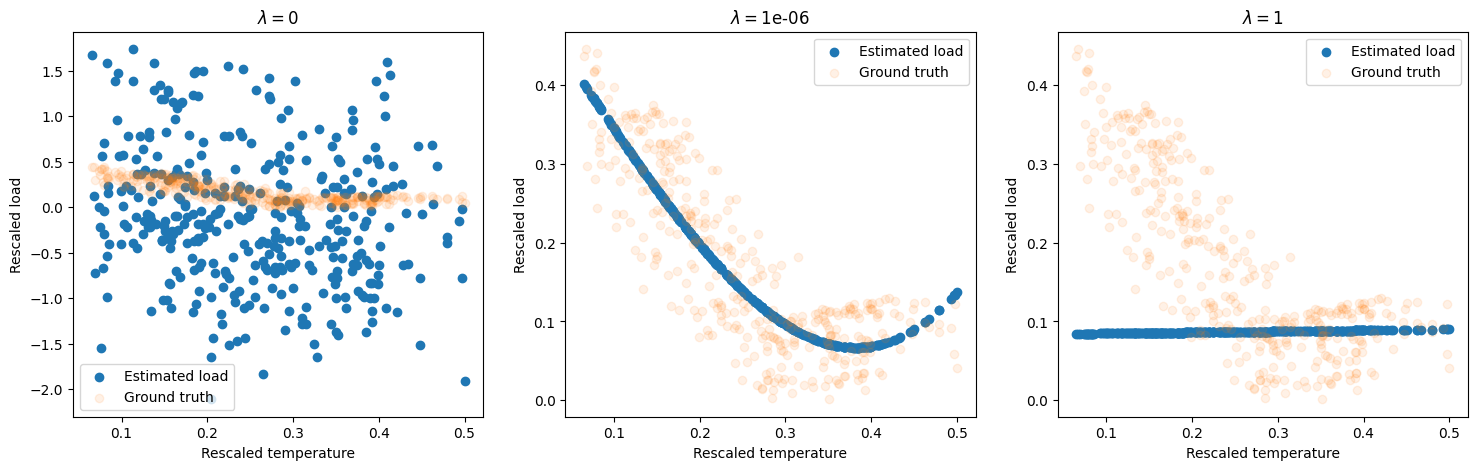

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

lambda_values = [0, 10**-6, 1]
temp_train = train_data['temperature']
temp_test = train_data['temperature']
load_train = train_data['Load']

for i in range(3):
  lambda_param = lambda_values[i]
  estimated_load = kernel_method(lambda_param, temp_train, load_train, temp_test)
  axs[i].scatter(temp_train, estimated_load, label = "Estimated load")
  axs[i].scatter(temp_train, train_data['Load'], alpha=0.1, label = "Ground truth")
  axs[i].set_title('$\lambda = $'+ str(lambda_param))
  axs[i].set_xlabel('Rescaled temperature')
  axs[i].set_ylabel('Rescaled load')
  axs[i].legend()


$\lambda = 0$ clearly overfits the training dataset, while $\lambda = 1$ clearly underfits. Thus, $\lambda = 10^{-6}$ is the best choice.

**Question 10.** Apply the kernel method to the test dataset. Plot the estimated load and compare it to the true value of *Load*. Compute its RMSE.

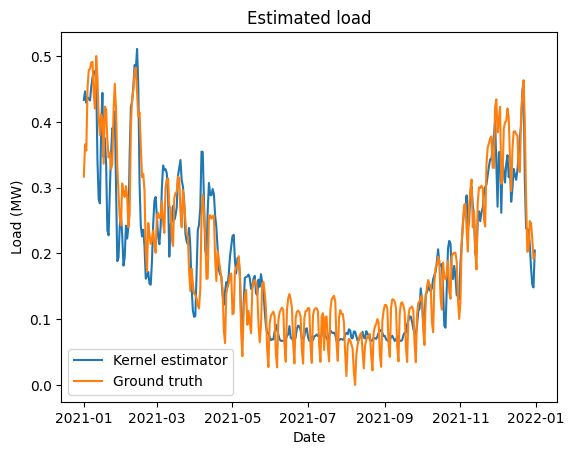

In [ ]:
lambda_param = 10**-6
temp_train = train_data['temperature']
temp_test = test_data['temperature']
load_train = train_data['Load']

estimated_load = kernel_method(lambda_param, temp_train, load_train, temp_test)

# Plotting the results
plt.plot(test_data['day'], estimated_load, label= "Kernel estimator")
plt.plot(test_data['day'], test_data['Load'], label="Ground truth")
plt.xlabel('Date')
plt.ylabel('Load (MW)')
plt.title('Estimated load')
plt.legend()

In [ ]:
print("The RMSE is ", np.sqrt(np.mean((estimated_load- test_data['Load'])**2)))

The RMSE is  0.049452730635208005


## 3- Fourier kernel

**Sobolev norm.** Here, the goal is to construct a kernel method tailored to take into acount the a priori knowledge that
* $\int_{0}^{0.5} (f^\star)^2 < \infty$
* $\int_{0}^{0.5} (\frac{d^j}{dx^j}f^\star)^2 < \infty$, for all $1\leq j\leq s$, for some $s\in \mathbb N^\star$.

The norm $\|f\|_{H^s}^2 = \int_{0}^{0.5} (f^\star)^2+ \sum_{j=1}^s(\frac{d^j}{dx^j}f^\star)^2$ is called the Sobolev-norm of order $s$. The space of functions with finite Sobolev norm is denoted by $H^s([0,0.5])$. The higher the smoothness parameter $s$, the more the function $f\in H^s([0,0.5])$ is differentiable.

Of course, if $s_1 > s_2$, then $H^{s_1}([0, 0.5]) \subseteq H^{s_2}([0, 0.5])\subseteq L^2([0,0.5])$.

In what follows, we admit the following result.

**Sobolev extension.**  There is a constant $C>0$ such that, for all $f\in H^s([0,0.5])$, there is a parameter $z\in \mathbb C^\mathbb Z$ such that
* $f(x) = \sum_{k\in\mathbb Z} z_k \exp(i 2\pi k x) $
* $\|f\|_{H^s}^2\leq \sum_{k\in \mathbb Z} |z_k|^2 (1+k^{2s}) \leq C \|f\|_{H^s}^2.$

**Question 12.** Find a map $\phi(x)$ and a parameterization $\theta$ such that, for all $f \in H^s([0, 0.5])$, there is a parameter $\theta \in \mathbb C^{\mathbb Z}$, such that
* $\|f\|_{H^s}^2 \leq \|\theta\|_2^2  \leq C \|f\|_{H^s}^2$
* $f(x) = \langle \phi(x), \theta \rangle$, where $\langle a,b\rangle = \sum_{k\in \mathbb C^\mathbb Z} \bar a_k b_k$ is the canonical inner product on $\mathbb C^\mathbb Z$.

**Answer.**
<details>
  <summary>  (Click to show)</summary>
  Using the Sobolev extension theorem, we can take
  
  * $\theta_k = (1+k^{2s})^{1/2}  z_k$
  * $\phi(x) = ((1+k^{2s})^{-1/2} \exp(-i 2\pi k x))_{k\in\mathbb Z}$.
</details>

**Question 13.** Deduce the kernel resulting from this mapping.

**Answer.**
<details>
  <summary>  (Click to show)</summary>
  $$K(x,y) = \langle \phi(x), \phi(y)\rangle = \sum_{k\in \mathbb C^\mathbb Z} \exp(i 2\pi k(x-y)) (1+k^{2s})^{-1}.$$
</details>

**Question 14.** We want to implement the kernel method associated with the Sobolev kernel with $s=2$. To do so, approximate the kernel using $100$ Fourier frequences and the formula
$$\hat \theta = (\Phi^*\Phi/n + \lambda I)^{-1}\Phi^* \mathbb Y/n,$$
where * is the conjugate-transpose operation and
$$\Phi = \begin{pmatrix}\phi(X_1)^*\\\vdots\\\phi(X_n)^*\end{pmatrix}.$$

a) Implement a function *phi_matrix* returning the matrix $\Phi$.

In [ ]:
def phi_matrix(s, temp_array):
  n = len(temp_array)
  temp_matrix = np.tile(temp_array.reshape(-1,1), 201)
  k_matrix = np.tile(np.arange(-100, 101), (n,1))
  sob_weights = (1+k_matrix**(2*s))**(-0.5)
  return np.multiply(sob_weights, np.exp(1j*2*np.pi*np.multiply(k_matrix,temp_matrix)))

b) Implement the function *sobolev_kernel_method* given an hyperparameter *lambda_param*.

In [ ]:
def dagger(mat):
  return mat.conj().T

def sobolev_kernel_method(s, lambda_param, temp_train, load_train, temp_test):
  n = len(temp_train)

  phi_mat = phi_matrix(s, temp_train)
  theta_hat = np.linalg.solve(dagger(phi_mat)@phi_mat/n + lambda_param*np.eye(201), dagger(phi_mat)@load_train/n)

  phi_mat_test = phi_matrix(s, temp_test)
  estimated_load = phi_mat_test@theta_hat
  return estimated_load

c) Test different values of $\lambda$ on the training dataset. Choose the best one.

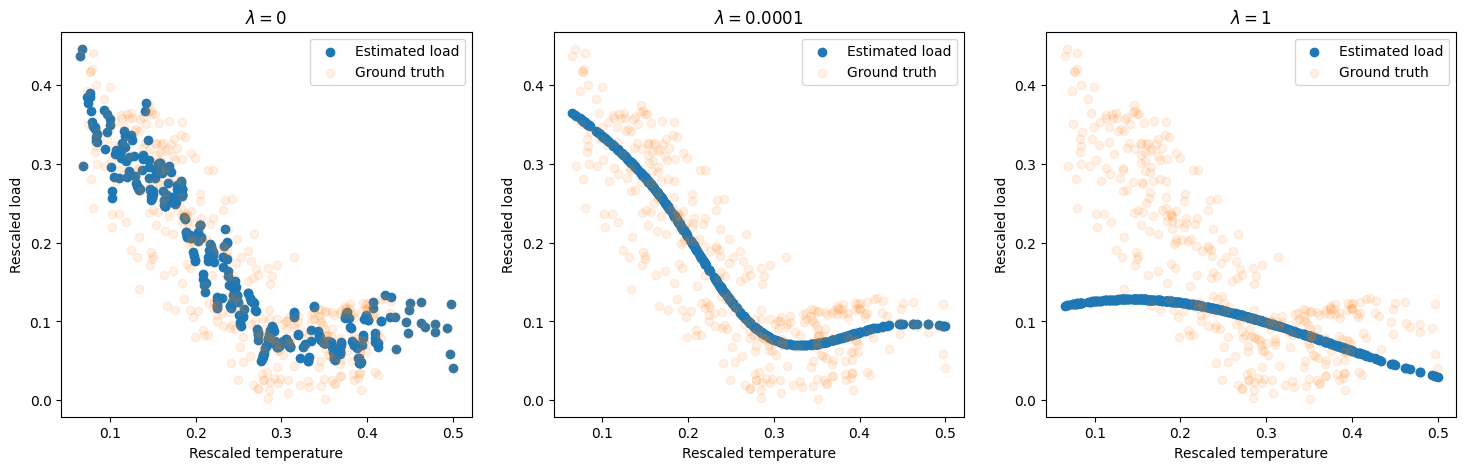

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

lambda_values = [0, 10**-4, 1]
temp_train = np.array(train_data['temperature'])
temp_test = np.array(train_data['temperature'])
load_train = np.array(train_data['Load'])

for i in range(3):
  lambda_param = lambda_values[i]
  estimated_load = sobolev_kernel_method(3, lambda_param, temp_train, load_train, temp_test)
  axs[i].scatter(temp_train, estimated_load, label = "Estimated load")
  axs[i].scatter(temp_train, train_data['Load'], alpha=0.1, label = "Ground truth")
  axs[i].set_title('$\lambda = $'+ str(lambda_param))
  axs[i].set_xlabel('Rescaled temperature')
  axs[i].set_ylabel('Rescaled load')
  axs[i].legend()


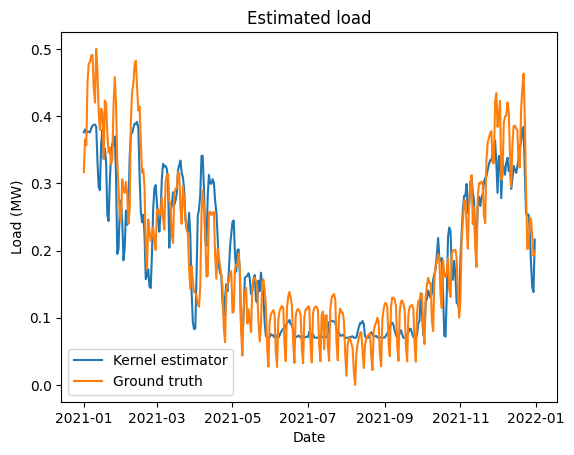

In [ ]:
lambda_param = 10**-4
temp_test = np.array(test_data['temperature'])

estimated_load = sobolev_kernel_method(3, lambda_param, temp_train, load_train, temp_test)

# Plotting the results
plt.plot(test_data['day'], estimated_load, label= "Kernel estimator")
plt.plot(test_data['day'], test_data['Load'], label="Ground truth")
plt.xlabel('Date')
plt.ylabel('Load (MW)')
plt.title('Estimated load')
plt.legend()

In [ ]:
print("The RMSE is ", np.sqrt(np.mean((np.abs(estimated_load- test_data['Load']))**2)))

The RMSE is  0.051753353792650635


## 4- Going Further

### 4.1- Comparing kernels

There are many different kernels, like

* linear regression: $K(x,y) = xy$,
* polynomial fit of order $k$: $K(x,y) = \frac{1-(xy)^{k+1}}{1-xy}$,
* Gaussian kernel: $K(x,y) = \exp((x-y)^2)$
* Sobolev or Matérn kernels...


**Question 15.** Explain why, though the Sobolev kernel is a better fit, it performs worse than the polynomial kernel on the test dataset.

**Answer.**
<details>
  <summary>  (Click to show)</summary>

  Part of the test dataset is in an extrapolation regime. Indeed, while the minimum temperature on the train dataset is $0.0649$, the temperature in the first month of the test dataset is around $0.04$. Thus, though the polynomial kernel underfits the data, it extrapolates more smoothly than the Sobolev kernel.

  The way a kernel extrapolates matters a lot to determine the right kernel method for a given task. Less powerful kernel (like linear regression $K(x,y) = xy$) often extrapolate more smoothly, as opposed to more sensitive kernels (like the Sobolev kernel).
</details>

In [ ]:
print("The minimum temperature on the training dataset is ", min(train_data['temperature']))
print("The average temperature in the first 15 day of the test dataset is ", (test_data['temperature'][:15]).mean())

The minimum temperature on the training dataset is  0.06497583183181957
The average temperature in the first 15 day of the test dataset is  0.0572263435138176


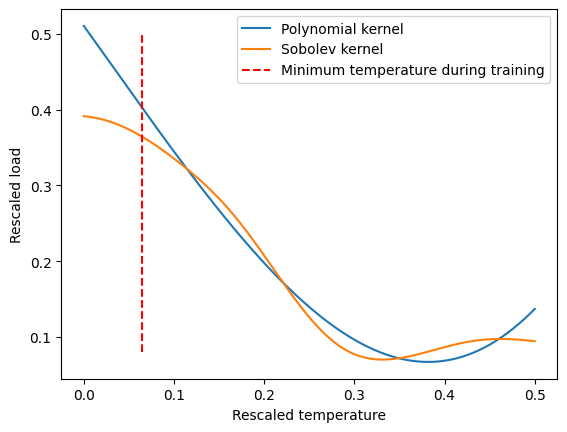

In [ ]:
temp_test = np.linspace(0, 0.5, 1000)

estimated_load = kernel_method(10**-6, temp_train, load_train, temp_test)
plt.plot(temp_test, estimated_load, label = "Polynomial kernel")

estimated_load = sobolev_kernel_method(3, 10**-4, temp_train, load_train, temp_test)
plt.plot(temp_test, estimated_load, label = "Sobolev kernel")
plt.vlines(min(train_data['temperature']), 0.08, 0.5, colors="red", linestyles='--', label="Minimum temperature during training")
plt.xlabel("Rescaled temperature")
plt.ylabel("Rescaled load")
plt.legend()


**Question 16.** As seen in the slides of Lecture 2, the $L^2$ error of a kernel method is then bounded by the effective dimension $\hbox{tr}((\Sigma + \lambda I)^{-1}\Sigma)$, where $\Sigma = \mathbb E(\Phi(X) \otimes \Phi(X))$ is the covariance operator, such that $\langle \theta_1, \Sigma \theta_2 \rangle = \mathbb E(\langle \theta_1, \Phi(X)\rangle \times \langle \theta_2, \Phi(X)\rangle)$ .

a) Show that $\Sigma$ is a positive symmetric operator.

b) If the output space of $\phi:\mathbb R \to \mathbb R^k$ is finite dimensional and if $\langle \cdot, \cdot\rangle$ is the canonical scalar product, describe $\Sigma$.

c) Assume the kernel is *bounded*, i.e., $\exists R > 0, \;\forall x,\; \|\phi(X)\|_2^2 \leq R$. Then, $\Sigma$ is a compact operator, and the spectral theorem states that it is diagonalizable. Write $\hbox{tr}((\Sigma + \lambda I)^{-1}\Sigma)$ as a function of the eigenvalues of $\Sigma$.

d) If the output space of $\phi:\mathbb R \to \mathbb R^k$ is finite dimensional, show that the effective dimension is bounded by $k$, independently of $\lambda$.

**Answer.**
<details>
  <summary>  (Click to show)</summary>

  a) $\langle \theta_1, \Sigma \theta_2 \rangle = \mathbb E(\langle \theta_1, \Phi(X)\rangle  \langle \theta_2, \Phi(X)\rangle) = \mathbb E( \langle \theta_2, \Phi(X)\rangle \langle \theta_1, \Phi(X)\rangle ) = \langle \theta_2, \Sigma \theta_1 \rangle = \langle \Sigma \theta_1, \theta_2  \rangle = \langle \theta_1, \Sigma^* \theta_2  \rangle $.
  Thus, $\Sigma^* = \Sigma$, meaning that $\Sigma$ is symmetric.

  $\langle \theta, \Sigma \theta \rangle = \mathbb E(\langle \theta_1, \Phi(X)\rangle^2)\geq 0$.
  Thus, $\Sigma$ is positive.

  b)  In this case, $\Sigma$ is a $k\times k$ matrix and $\Sigma_{i,j} = \mathbb E(\Phi_i(X) \Phi_j(X))$.

  c) Let $\sigma(\Sigma) = \{\sigma_\ell, \ell\in \mathbb N\}$ be the spectrum of $\Sigma$ (with multiplicity) and $\{v_\ell, \ell\in \mathbb N\}$ be the corresponding eigenvectors. Then, $\Sigma$, $I$, and $\Sigma + \lambda I$ are diagonalizable in the same basis of eigenvectors, and
  $$(\Sigma + \lambda I)^{-1}\Sigma = \sum_{\ell\in \mathbb N} \frac{\sigma_\ell}{\sigma_\ell + \lambda} v_\ell.$$
  We deduce that
  $$\hbox{tr}((\Sigma + \lambda I)^{-1}\Sigma) = \sum_{\ell\in \mathbb N} \frac{\sigma_\ell}{\sigma_\ell + \lambda}.$$

  d) Since $\sigma_\ell \geq 0$, we have that $1\geq \frac{\sigma_\ell}{\sigma_\ell + \lambda}\geq 0$. Thus, if the output space of $\phi:\mathbb R \to \mathbb R^k$ is finite dimensional, then $\Sigma$ is a $k\times k$ matrix and
  $$\hbox{tr}((\Sigma + \lambda I)^{-1}\Sigma) = \sum_{\ell=1}^k \frac{\sigma_\ell}{\sigma_\ell + \lambda} \leq k.$$
</details>

**Question 17.** How to choose the best kernel for a given task, from a theoretical perspective?

**Answer.**
<details>
  <summary>  (Click to show)</summary>

  (i) First, kernels always make the inherent assumption that
  
  * $\exists \theta^\star, \; f^\star(x) = \langle  \phi(x), \theta^\star\rangle$,
  * $\|\theta^\star\|_2^2 < \infty$.

  Thus, a kernel is well-suited to a supervised learning task if this assumption holds. We say that $f^\star$ belongs to the RKHS. This argument can be generalized if $f^\star$ does not strictly belongs to the RKHS, but can be approximated with a high precision by a function from the RKHS.

  For example, using the polynomial fit of order $k$ amounts to assuming the $f^\star$ is a polynomial of order $k$. Using the Sobolev kernel of order $s$ amounts to assuming that  $f^\star$ is $s$ times differentiable.

  The first criterion regarding the approximation capabilities of the kernel tends to favor highly adaptive kernels. For example, kernels able to approximate any continous functions, like Gaussian and Sobolev kernels, are called *universal kernels*.


  (ii) As seen in the slides of Lecture 2 and recalled in Question 16, the $L^2$ error of a kernel method is then bounded by the effective dimension of the kernel. Therefore, if $f^\star$ belongs to two RKHS, we should choose the RKHS with the lowest effective dimension. With finite-dimensional RKHS, this amounts to choosing the representation of lower dimension.

  (iii) Finally, extrapolation capabilities (discussed in Question 15) are important if the data distribution slightly shifts between the training and the testing data.

</details>

### 4.2 - Multidimensional kernels

**Question 18.** Let $d\in \mathbb N$ be the input dimension.

a) Find a map $\phi$ such that any periodic function function $f$ on $[-\pi, \pi]^d$, there is a parameter $\theta \in \mathbb C^{\mathbb Z^d}$ such that
$$f(x) = \langle\phi(x), \theta \rangle.$$

b) Given
* a map $\phi$ such that $f(x) = \langle \phi(x), \theta\rangle$
* an invertible Hermitian operator $M: \mathbb C^{\mathbb Z^d}\to \mathbb C^{\mathbb Z^d}$,

we still have that $f(x) = \langle M\theta, M^{-1}\phi(x)\rangle$. What changes when considering this new map $\phi_2(x) = M^{-1}\phi(x)$?

c) Let $\alpha = (\alpha_1, \dots, \alpha_d)\in \mathbb N^d$ be a multi-index.
The partial derivative along $\alpha$ is defined by $\partial^\alpha = \partial_1^{\alpha_1}\dots\partial_d^{\alpha_d}$.

Parseval's theorem states that
$$\int_{[-\pi, \pi]^d} (\partial^\alpha f)^2 = (2\pi)^d k_1^{2\alpha_1}\dots k_d^{2\alpha_d} \|\theta\|_2^2.$$

Find a matrix $M$ encoding the Sobolev norm
$$\|f\|_{H^s([-\pi, \pi]^d)}^2 = \sum_{\|\alpha\|_1 \leq s}\int_{[-\pi, \pi]^d} (\partial^\alpha f)^2.$$

d) Assume $s>d/2$ and $\lambda >0$. Show that
$$\hat \theta = \hbox{argmin}_{\theta} \frac{1}{n}\sum_{j=1}^n (f(X_i)-Y_i)^2 + \lambda \|f\|_{H^s([-\pi,\pi]^d)}^2$$
is a kernel method.


**Answer.**
<details>
  <summary>  (Click to show)</summary>

  a) We use the Fourier series expansion of $f$,
  $$f(x) = \sum_{k\in \mathbb C^{\mathbb Z^d}} z_k \exp(i \langle k, x\rangle).$$

  Then, setting $\theta_k =  z_k$, we have
  $$\phi(x) = (\exp(-i \langle k, x\rangle))_{k\in \mathbb Z^d}.$$

  b) Considering the map $\phi(x) = (\exp(-i \langle k, x\rangle))_{k\in \mathbb Z^d}$ does not change the approximation capabilities of the kernel method. However, the empirical risk becomes

  $$\hat \theta = \hbox{argmin}_{\theta} \frac{1}{n}\sum_{j=1}^n (f(X_i)-Y_i)^2 + \lambda \|M\theta\|_2^2.$$

  Therefore, the norm of $f^\star$ becomes $\|M\theta^\star\|_2$ instead of $\|\theta^\star\|_2$.

  Moreover, the covariance matrix  becomes $\Sigma = \mathbb E((M^{-1}\phi(X))\otimes (M^{-1}\phi(X))$. Since its eigenvalues changes, the effective dimension changes.

  c) $M$ is the diagonal matrix such that $M_k = (\sum_{\|\alpha\|_2 \leq s}(2\pi)^d k_1^{2\alpha_1}\dots k_d^{2\alpha_d})^{1/2}$.

  d) This amounts to find a parameter $\theta$ minimizing

  $$L(\theta) =  \frac{1}{n}\sum_{j=1}^n (f_\theta(X_i)-Y_i)^2 + \lambda \|M\theta\|_{H^s([-\pi,\pi]^d)}^2.$$

  The corresponding kernel is
  $$K(x,y) = \langle M^{-1} \phi(x), M^{-1} \phi(y)\rangle = \sum_{k\in \mathbb Z^d} \frac{\exp(i \langle k, x-y\rangle)}{\sum_{\|\alpha\|_2 \leq s}(2\pi)^d k_1^{2\alpha_1}\dots k_d^{2\alpha_d}}.$$
  $1+\|k\|_2^{2s}$ is a polynomial in $(k_1^2, \dots, k_d^2)$ of degree $s$. Thus, there is a constant $C>0$ such that
  $$\sum_{\|\alpha\|_2 \leq s} k_1^{2\alpha_1}\dots k_d^{2\alpha_d} \geq C (1+\|k\|_2^{2s}).$$
  Therefore,
  $$\sum_{k\in \mathbb Z^d} |\frac{\exp(i \langle k, x-y\rangle)}{\sum_{\|\alpha\|_2 \leq s}(2\pi)^d k_1^{2\alpha_1}\dots k_d^{2\alpha_d}}| \leq \sum_{k\in \mathbb Z^d} \frac{1}{C (2\pi)^d (1+\|k\|_2^{2s})}.$$
  But $\sum_{k\in \mathbb Z^d} \frac{1}{C (2\pi)^d (1+\|k\|_2^{2s})} < \infty$ if and only if $s>d/2$.

  Thus, the series is absolutely convergent and $K$ is well-defined and bounded by $\sum_{k\in \mathbb Z^d} \frac{1}{C (2\pi)^d (1+\|k\|_2^{2s})} $.
</details>

### 4.3 - Algorithmic considerations

**GPUs.** Kernel methods often rely heavily on linear algebra operations, making them well-suited for implementation on GPUs, which are optimized for such workloads.


**Matrix inversion.** In practice, to compute
$$\hat \theta = (\Phi^*\Phi/n + \lambda I)^{-1}\Phi^* \mathbb Y/n, $$
cexplicitly inverting the matrix $\Phi^*\Phi/n + \lambda I$ and then multiplying by $\Phi^* \mathbb Y/n$ is numerically unstable.
This instability arises because numbers in Python (and most programming languages) are represented using finite-precision base-2 arithmetic, which can lead to significant rounding errors, especially in ill-conditioned problems.

Instead of direct inversion, solvers such as *torch.solve* (which internally uses LU decomposition) are preferred.
Such solvers rely on the LU decomposition of the matrix $A$ to compute $y = A^{-1} x$. Its complexity is still $O(p^3)$, if $A$ is an $p\times p$ matrix though.

Moreover, for large-scale problems, iterative methods like conjugate gradient descent or specialized algorithms exploiting the Toeplitz structure of some specific kernel matrices can reduce both computational cost and memory usage, making them more scalable alternatives.
